### Getting start

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GenAI-CUEE/EE208-Introduction-to-programming-for-EE/blob/master/L4_Runtime_measurement/Profiling_w_libraries.ipynb)

- [Installing packages](#installing-packages)
- [Knowing your data](#reading-input-image)
- [Defin kernel and  Conv2D operation](#define-the-kernel-and-2d-convolution-operation)

Here we present 3 approaches to measure the runtime perfromance

- [1. Time difference](#1-measure-the-time-difference)
    - [Time library](#11-timetime)
    - [cProfile library](#12-cprofile)
- [2. Macs and flop-counts](#2-measure-macs-flop-counts-and-runtime-by-converting-into-torchnnmodule)
    - [Operation counter (thop)](#21-thop-profiler)
    - [Torch profiler](#22-torchprofiler)
- [3. FLOP/S](#3-flops)
    - [FLOPS profiler](#31-flops-profiler)

### Installing packages

In [ ]:
! pip3 install torch torchvision torchaudio numpy
! python -m pip install -U matplotlib
! pip install thop 
! pip install flops-profiler

In [19]:
import numpy as np
import time 
from datetime import timedelta 
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
import torchvision.transforms as transforms 

## Reading input image

(-0.5, 639.5, 359.5, -0.5)

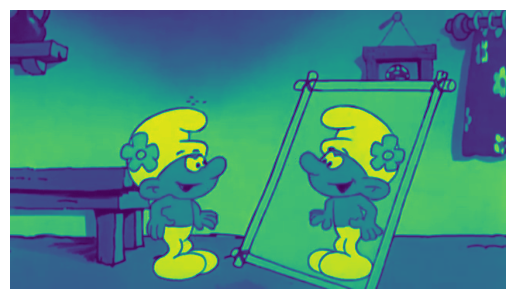

In [20]:
im          = Image.open("Smurfs500.jpg") #These two lines
im_arr      = np.array(im)
image_sum   = im_arr.sum(axis=2)
im_arr      = image_sum/image_sum.max() 

h, w = im_arr.shape
plt.imshow(im_arr) 
plt.axis("off")

## Define the kernel and Conv2D operation

In [21]:
# Define a kernel

simple_kernel = np.array([[0,1,0],[1, 0, 1],[0,1,0]])

def gaussuian_kernel(kernel_size, sigma=1, muu=0): 
    # Initializing value of x,y as grid of kernel size  
    x, y = np.meshgrid(np.linspace(-1, 1, kernel_size),
                       np.linspace(-1, 1, kernel_size))
    dst = np.sqrt(x**2+y**2) 
 
    # Calculating Gaussian filter
    gauss = (1/(2 * np.pi * sigma**2)) * np.exp(-((dst-muu)**2 / (2.0 * sigma**2))) 

    return gauss


kernel = gaussuian_kernel(3)

def convolution2d(image, kernel):
    ky, kx = kernel.shape 
    y, x = image.shape
    y = y - ky + 1
    x = x - kx + 1
    new_image = np.zeros((y,x))
    for i in range(y):
        for j in range(x):
            new_image[i][j] = np.sum(image[i:i+ky, j:j+kx]*kernel) 

    return new_image




def main(im_arr, kernel):
    
    newimage  = convolution2d(im_arr, kernel) 
    return newimage

## 1. Measure the time difference

Time difference can be measured directly through the computer system time or using native tools, e.g., time and cProfile.

### 1.1 Time.time()

In [22]:
### Start 
starttime = time.perf_counter() 

newimage  = convolution2d(im_arr, kernel)

### Stop 
duration  = timedelta(seconds=time.perf_counter()-starttime) 
print('Job took: %.3f ms' % (duration.microseconds/1000))  

Job took: 416.481 ms


### 1.2 cProfile

In [ ]:
import cProfile, pstats
profiler = cProfile.Profile()
profiler.enable()
 
newimage = main(im_arr, kernel)

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats()

#### Check the results from the convolutional operation

(-0.5, 637.5, 357.5, -0.5)

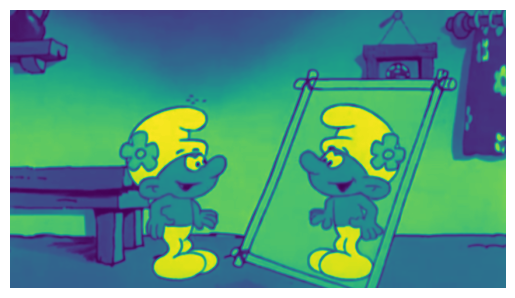

In [24]:
plt.imshow(newimage) 
plt.axis("off")

## 2. Measure MACs, flop counts, and runtime by converting into torch.nn.Module()

In [25]:
# Define a simple neural network with a single 2D convolutional layer
class CustomKernel(nn.Module):
    def __init__(self, in_channels, out_channels, kernel):
        super(CustomKernel, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel.shape, stride=1, padding=1)

        # Set the convolution weights using the custom kernel
        for i in range(out_channels):
            for j in range(in_channels):
                self.conv.weight.data[i, j, :, :] = torch.tensor(kernel, dtype=torch.float32)  # Apply the custom kernel 

        self.conv.bias.data.fill_(0)  # Set the bias to zero 
        
    def forward(self, x): 
        return self.conv(x)
 
Conv_Network = CustomKernel(in_channels=1, out_channels=1, kernel=kernel)
im_arr       = torch.tensor(im_arr.reshape(1,1,h,w), dtype=torch.float32) 

### 2.1 thop Profiler

In [26]:
from thop import profile

macs, params = profile(Conv_Network, inputs=(im_arr, ))
print("thop: MACs: %d, Params: %d" % (macs, params))

# Just to cross-check the runtime ...

### Start 
starttime = time.perf_counter() 

convolved_image = Conv_Network(im_arr.view(1,1,h,w))

### Stop 
duration  = timedelta(seconds=time.perf_counter()-starttime) 

print('Job took: %.3f ms' % (duration.microseconds/1000))  

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
thop: MACs: 2073600, Params: 10
Job took: 0.222 ms


### 2.2 Torch.Profiler 

- Self Time: For a function, is the amount of time to execute code within the function (inline statements). Checking the performance of individual functions is known as bottom-up analysis.

- Total Time: For a function, is the self time of that function and the self times of all functions that function calls. Checking the performance of functions along with their callees is top-down analysis.

- \# of Calls : Just because a function has a high self time, doesn't mean that the function itself is inefficient. It is also important to look at how many times that function is being called.

In [27]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True, with_flops=True) as prof:
    with record_function("model_inference"):
        convolved_image = Conv_Network(im_arr.view(1,1,h,w))

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
prof.export_chrome_trace("trac_conv2d.json")

----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  Total MFLOPs  
----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
             model_inference        51.72%     241.000us       100.00%     466.000us     466.000us             1            --  
                aten::conv2d         0.86%       4.000us        47.21%     220.000us     220.000us             1         4.147  
           aten::convolution         3.65%      17.000us        46.35%     216.000us     216.000us             1            --  
          aten::_convolution         1.72%       8.000us        42.70%     199.000us     199.000us             1            --  
    aten::mkldnn_convolution        39.27%     183.000us        40.99%     191.000us     191.000u

STAGE:2024-05-24 22:19:19 467378:467378 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-24 22:19:19 467378:467378 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-24 22:19:19 467378:467378 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


(-0.5, 639.5, 359.5, -0.5)

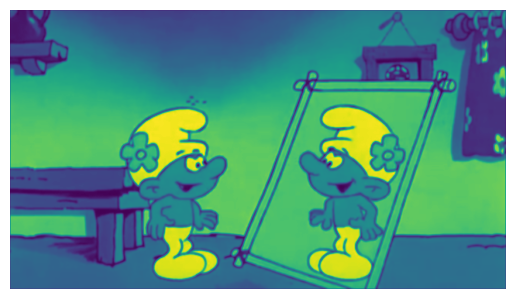

In [28]:
plt.imshow(convolved_image.view(h,w).detach().numpy()) 
plt.axis("off")

## 3. FLOP/s 

### 3.1 Flops-profiler

In [29]:
import torchvision.models as models
import torch
from flops_profiler.profiler import get_model_profile

with torch.cuda.device(0):
    model = Conv_Network
    batch_size = 1
    flops, macs, params = get_model_profile(model=model, # model
                                    input_shape=(batch_size, 1, h, w), # input shape to the model. If specified, the model takes a tensor with this shape as the only positional argument.
                                    args=None, # list of positional arguments to the model.
                                    kwargs=None, # dictionary of keyword arguments to the model.
                                    print_profile=True, # prints the model graph with the measured profile attached to each module
                                    detailed=True, # print the detailed profile
                                    module_depth=-1, # depth into the nested modules, with -1 being the inner most modules
                                    top_modules=1, # the number of top modules to print aggregated profile
                                    warm_up=10, # the number of warm-ups before measuring the time of each module
                                    as_string=True, # print raw numbers (e.g. 1000) or as human-readable strings (e.g. 1k)
                                    output_file=None, # path to the output file. If None, the profiler prints to stdout.
                                    ignore_modules=None, # the list of modules to ignore in the profiling
                                    func_name='forward') # the function name to profile, "forward" by default, for huggingface generative models, `generate` is used


-------------------------- Flops Profiler --------------------------
Profile on Device: cpu
Profile Summary at step 10:
Notations:
data parallel size (dp_size), model parallel size(mp_size),
number of parameters (params), number of multiply-accumulate operations(MACs),
number of floating-point operations (flops), floating-point operations per second (FLOPS),
fwd latency (forward propagation latency), bwd latency (backward propagation latency),
step (weights update latency), iter latency (sum of fwd, bwd and step latency)

params per device:                                            10      
params of model = params per device * mp_size:                10      
fwd MACs per device:                                          2.07 MMACs
fwd flops per device:                                         4.38 M  
fwd flops of model = fwd flops per device * mp_size:          4.38 M  
fwd latency:                                                  6.13 ms 
fwd FLOPS per device = fwd flops per device